In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout

In [ ]:
import zipfile

# Define the path to your ZIP file and the files you want to add
zip_file_path = '/content/drive/MyDrive/traficSignalDataset.zip'
# Define the directory where you want to extract the files
extract_to_directory = '/content'

# Open the ZIP file for reading
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    # Extract all files and directories to the specified directory
    zipf.extractall(extract_to_directory)

print("Files extracted successfully.")

Files extracted successfully.


In [ ]:
imgs_path = "/content/Train"

In [ ]:
data = []
labels = []
classes = 43
for i in range(classes):
    img_path = os.path.join(imgs_path, str(i))  # Subdirectory for each class (0-42)

    for img_name in os.listdir(img_path):
        img_path_full = os.path.join(img_path, img_name)  # Full path to the image
        im = Image.open(img_path_full)
        im = im.resize((30, 30))
        im = np.array(im)
        data.append(im)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)
print("Success")


Success


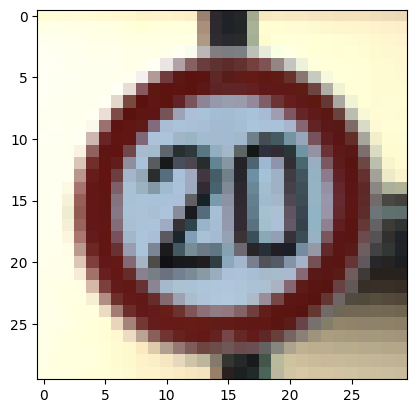

In [ ]:
path = "/content/Train/0/00000_00004_00029.png"
img = Image.open(path)
img = img.resize((30, 30))
sr = np.array(img)
plt.imshow(img)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_test.shape, y_test.shape)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

training shape:  (31367, 30, 30, 3) (31367,)
testing shape:  (7842, 30, 30, 3) (7842,)


In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model
optimizer = Adam(lr=0.001)  # You can adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
491/491 [==============================] - 16s 9ms/step - loss: 2.2689 - accuracy: 0.4738 - val_loss: 0.5398 - val_accuracy: 0.8790
Epoch 2/15
491/491 [==============================] - 5s 10ms/step - loss: 0.7468 - accuracy: 0.7952 - val_loss: 0.2740 - val_accuracy: 0.9278
Epoch 3/15
491/491 [==============================] - 4s 8ms/step - loss: 0.4969 - accuracy: 0.8593 - val_loss: 0.1354 - val_accuracy: 0.9675
Epoch 4/15
491/491 [==============================] - 3s 7ms/step - loss: 0.3795 - accuracy: 0.8907 - val_loss: 0.1569 - val_accuracy: 0.9601
Epoch 5/15
491/491 [==============================] - 4s 9ms/step - loss: 0.3309 - accuracy: 0.9024 - val_loss: 0.0940 - val_accuracy: 0.9778
Epoch 6/15
491/491 [==============================] - 3s 6ms/step - loss: 0.2872 - accuracy: 0.9158 - val_loss: 0.0796 - val_accuracy: 0.9764
Epoch 7/15
491/491 [==============================] - 3s 7ms/step - loss: 0.2444 - accuracy: 0.9291 - val_loss: 0.1056 - val_accuracy: 0.9688
Epoc

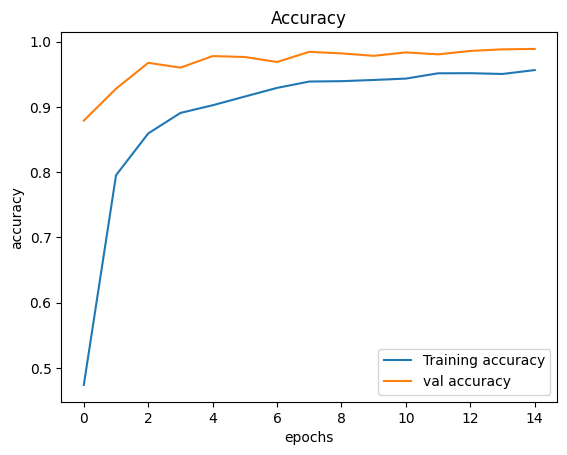

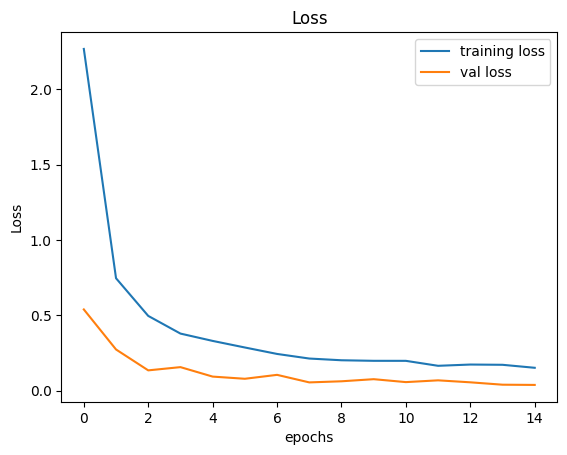

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

test = pd.read_csv("/content/Test.csv")
test_true_labels = test['ClassId'].values  # Renamed to avoid variable name collision
test_img_path = "/content"
test_imgs = test['Path'].values
test_data = []

for img in test_imgs:
    im = Image.open(test_img_path + '/' + img)
    im = im.resize((30, 30))
    im = np.array(im)
    test_data.append(im)

test_data = np.array(test_data)
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

accuracy = accuracy_score(test_true_labels, predicted_classes)
print("Accuracy:", accuracy)

395/395 [==============================] - 1s 2ms/step
Accuracy: 0.9452098178939035


In [ ]:
model.save('traffic_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def classify_image(file_path):
    image = Image.open(file_path)
    image = image.resize((30, 30))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    pred_class = np.argmax(predictions, axis=-1)[0] + 1  # Adding 1 to match your class numbering
    sign = classes[pred_class]
    return sign

In [ ]:
from keras.models import load_model
from PIL import Image
import numpy as np

# Load the trained model to classify traffic signs
model = load_model('/content/traffic_classifier.h5')

# Dictionary to label all traffic signs classes
classes = {1: 'Speed limit (20km/h)', 2: 'Speed limit (30km/h)', 3: 'Speed limit (50km/h)',
           4: 'Speed limit (60km/h)', 5: 'Speed limit (70km/h)', 6: 'Speed limit (80km/h)',
           7: 'End of speed limit (80km/h)', 8: 'Speed limit (100km/h)', 9: 'Speed limit (120km/h)',
           10: 'No passing', 11: 'No passing veh over 3.5 tons', 12: 'Right-of-way at intersection',
           13: 'Priority road', 14: 'Yield', 15: 'Stop', 16: 'No vehicles',
           17: 'Veh > 3.5 tons prohibited', 18: 'No entry', 19: 'General caution',
           20: 'Dangerous curve left', 21: 'Dangerous curve right', 22: 'Double curve',
           23: 'Bumpy road', 24: 'Slippery road', 25: 'Road narrows on the right',
           26: 'Road work', 27: 'Traffic signals', 28: 'Pedestrians', 29: 'Children crossing',
           30: 'Bicycles crossing', 31: 'Beware of ice/snow', 32: 'Wild animals crossing',
           33: 'End speed + passing limits', 34: 'Turn right ahead', 35: 'Turn left ahead',
           36: 'Ahead only', 37: 'Go straight or right', 38: 'Go straight or left',
           39: 'Keep right', 40: 'Keep left', 41: 'Roundabout mandatory',
           42: 'End of no passing', 43: 'End no passing veh > 3.5 tons' }

def classify_image(file_path):
    try:
        image = Image.open(file_path)
        image = image.resize((30, 30))
        image = np.array(image)
        image = np.expand_dims(image, axis=0)
        predictions = model.predict(image)
        pred_class = np.argmax(predictions, axis=-1)[0] + 1  # Adding 1 to match your class numbering
        sign = classes[pred_class]
        return sign
    except Exception as e:
        return f"Error: {e}"

def main():
    while True:
        file_path = input("Enter the path to the image (or 'exit' to quit): ")
        if file_path.lower() == 'exit':
            break
        sign = classify_image(file_path)
        print(f"Predicted Traffic Sign: {sign}")

if __name__ == "__main__":
    main()


Enter the path to the image (or 'exit' to quit): /content/train/0/00000_00000_00000.png
1/1 [==============================] - 0s 275ms/step
Predicted Traffic Sign: Speed limit (20km/h)
Enter the path to the image (or 'exit' to quit): exit
